# TME UE IAR: From Traditional EA to Quality-Diversity algorithms

Cette séance de TME consiste à mettre en oeuvre des méthodes d'apprentissage de type "direct policy search" s'appuyant sur des algorithmes évolutionnistes. 

Ces algorithmes s'appuient sur des opérateurs de recherche stochastiques. Si vous lancez plusieurs fois une même expérience avec une graine aléatoire différente vous obtiendrez des résultats différents. Dans la mesure du possible et de la puissance de calcul que vous avez à disposition et s'il n'a pas été demandé explicitement de ne faire qu'une seule expérience, il est donc souhaitable de répéter les expériences plusieurs fois avant de conclure.

Les cellules à compléter sont marquées <à compléter>.

Vous prendrez soin de ne soumettre que les fichiers nécessaires (merci d'éviter les fichiers de log inutiles et de taille conséquente...).

## 1. Introduction



### 1.1 Dépendances

L'environnement `FastsimSimpleNavigation-v0` de gym_fastsim permet de lancer des expériences de navigation avec un robot à roues naviguant dans un labyrinthe. Il se présente sous la forme d'une bibliothèque en C++ (libfastsim), d'une interface en python (pyfastsim) et d'une interface gym (fastsim_gym). Ces trois bibliothèques vous sont fournies avec un README qui explique comment les installer. En bref:
* libfastsim: `./waf configure` et `./waf build` (dépendance optionnelle SDL 1.2)
* pyfastsim: `pip3 install .` (dépendances: compilateur compatible c++14, module pybind11 avec module de développement associé)
* fastsim_gym: `pip3 install .` (dépendance: gym)




### 1.2 Code fourni

Le code vous permettant de reproduire les expériences de Lehman et Stanley sur la recherche de nouveauté vous est fourni (ceux qui ont suivi l'UE robotique et apprentissage de M1 l'ont fait en TME l'an dernier).

Contenu des fichiers fournis:
* fixed_structure_nn_numpy.py: réseau de neurones à structures fixe qui servira de politique paramétrée
* maze_plot.py: fonctions pour tracer l'espace comportemental associé aux expériences de Lehman et Stanley (navigation dans un labyrinthe)
* plot.py: fonctions pour tracer des fronts de pareto

Code à modifier/compléter:
* ea_dps.py: c'est le fichier principal pour lancer une expérience 
* novelty_search.py: gestion d'un objectif de nouveauté
* grid_management.py: gestion d'une grille pour suivre l'avancement de l'exploration et implémenter MAP-Elites

Ce code inclut des facilités pour enregistrer des logs, sauvegarder des trajectoires et les tracer ensuite.



### 1.3 Import

In [1]:
# Il n'y a rien à faire d'autre que d'exécuter cette cellule, 
# elle contient des imports qui vous seront utiles
# Note: l'import d'un fichier ne se fait qu'une seule fois. Si vous modifiez ce fichier, 
# il vous faut redémarrer votre kernel si vous voulez prendre en compte les modifications.
# vous pouvez éviter cela de la façon suivante: 
import importlib # une seule fois
import plot # le module doit avoir été importé une première fois
importlib.reload(plot) # cette ligne permet de charger la dernière version
import matplotlib.pyplot as plt
import cma
import gym, gym_fastsim
from deap import *
import numpy as np
from fixed_structure_nn_numpy import SimpleNeuralControllerNumpy
from scipy.spatial import KDTree
import datetime
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import array
import random
import operator
import math
import os.path
from plot import *
from scoop import futures
#from novelty_search_vanila import *
from novelty_search import *
import os
import grid_management
# pour que les figures apparaissent directement dans le notebook
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


Afin de faciliter les traitements par la suite sur des larges volumes de données, on scan au début du notebook le dossier contenant les runs terminées et on construit un dataframe qui rendra possible par la suite des opérations d'aggrégations efficacement.

In [2]:
import os
import ast
import re
import pandas as pd

runs_path = "completed_runs"

def process_runs(path):
    dirs = os.listdir(path)
    records = []
    current_gen = 0
    for i in dirs:
        generation = None
        with open(path+"/"+i+"/info.log","r") as file:
            for line in file.readlines():
                if("#" in line):
                    generation = int(re.findall(r"Generation (\d+)",line)[0])
                else:    
                    d = (ast.literal_eval(line))
                    t = (i, generation, *d.values())
                    t = (*t[:-1],*t[-1])
                    records.append(t)
    df = pd.DataFrame.from_records(records, columns=["Execution","Generation"]+list(d.keys())[:-1]+["pos_x","pos_y","angle"])
    return df

df = process_runs(runs_path)
df

Execution  Generation  collision  \
0          res_fastsim_NS_2020_12_23_21:24:38           0          0   
1          res_fastsim_NS_2020_12_23_21:24:38           0          0   
2          res_fastsim_NS_2020_12_23_21:24:38           0         10   
3          res_fastsim_NS_2020_12_23_21:24:38           0         10   
4          res_fastsim_NS_2020_12_23_21:24:38           0          0   
...                                       ...         ...        ...   
80195  res_fastsim_FIT_NS_2020_12_23_21:40:50         200       1000   
80196  res_fastsim_FIT_NS_2020_12_23_21:40:50         200       1000   
80197  res_fastsim_FIT_NS_2020_12_23_21:40:50         200       1000   
80198  res_fastsim_FIT_NS_2020_12_23_21:40:50         200       1000   
80199  res_fastsim_FIT_NS_2020_12_23_21:40:50         200         84   

         dist_obj  exit_reached       pos_x       pos_y     angle  
0     -354.539156           0.0   82.458977  413.827087  0.502213  
1     -390.000000           0.0   60.000000  450.000000 -2.814602  
2     -457.619447           0.0   16.981213  515.592957 -3.015227  
3     -481.786336           0.0  294.139618  481.066162 -0.610602  
4     -390.000000           0.0   60.000000  450.000000 -1.897787  
...           ...           ...         ...         ...       ...  
80195 -449.478155           0.0  495.390015  171.651901  2.182344  
80196 -383.996519           0.0  239.800339  399.300995 -2.860311  
80197 -200.012605           0.0  260.012604   59.975239  2.986899  
80198  -77.709559           0.0  137.709488   59.894768 -3.106446  
80199 -481.631399           0.0  295.407532  480.181030 -0.608952  

[80200 rows x 8 columns]

## 2 Comparaison des expériences de Fit, NS et Fit+NS

Cette première partie vise à vous faire prendre en main le code de l'expérience de navigation dans un labyrinthe et ses variantes NS, FIT et FIT+NS. 

Vous regarderez attentivement le fichier ea_dps.py et vous le compléterez pour afficher un message chaque fois qu'une politique s'approche de la sortie plus que ce qui a été fait auparavant. A cette occasion, vous sauvegarderez la trajectoire de cet individu (vous devrez pour cela le réévaluer en mettant le paramètre dump à True) pour pouvoir la tracer ensuite dans les questions suivantes de ce notebook.

### 2.1 Variante Fit

Lancez quelques expériences avec la variante FIT et indiquez le nombre moyen de générations pour atteindre la sortie (avec un nombre maximum de générations de 200). Vous pouvez l'obtenir en regardant les fichiers info.log générés et en cherchant la première génération où apparait un 'exit_reached': 1.0.



Afin de pouvoir gérer les expériences sur les différentes variantes nous avons inclu une modification permettant de préciser l'environnement a l'appel de la commande comme suit :

In [86]:
!python3 -m scoop ea_dps.py "fastsim_FIT"

[2020-12-22 12:32:48,458] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0], API: 1013
[2020-12-22 12:32:48,458] launcher  INFO    Deploying 8 worker(s) over 1 host(s).
[2020-12-22 12:32:48,458] launcher  INFO    Worker distribution: 
[2020-12-22 12:32:48,458] launcher  INFO       127.0.0.1:	7 + origin
/home/mohamed/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'MyFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/mohamed/.local/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previou

In [88]:
#a présent étant donné que nous avons construit des dataframe il devient facile d'effectuer des aggrégations sur
#les différentes exécutions ! 
df[df.Execution.str.contains("FIT_2")].groupby("Execution").exit_reached.max()

Execution
res_fastsim_FIT_2020_12_22_11:37:54    0.0
res_fastsim_FIT_2020_12_22_11:45:32    0.0
res_fastsim_FIT_2020_12_22_11:53:35    0.0
res_fastsim_FIT_2020_12_22_12:10:13    0.0
res_fastsim_FIT_2020_12_22_12:32:50    0.0
Name: exit_reached, dtype: float64

Comme on peut le voire en 200 itérations avec la configuration actuelle l'agent ne parviens pas a trouver la sortie quand il est guidé par le "FIT"

Tracez les trajectoires générées par les individus qui ont fait progresser la fitness pendant une expérience. Vous pourrez utiliser la fonction plot_traj_file qui est dans le fichier maze_plot.py.

In [70]:
execution_name = "res_fastsim_FIT_2020_12_22_12:32:50"

def points_generator_constructor(execution_name):
    def points_generator():
        agg = df[df.Execution == execution_name].groupby("Generation")["dist_obj"]
        for k in agg.groups:
            arr = np.array(df.loc[agg.groups[k]]["dist_obj"])
            indices = arr.argsort()[-3:][::-1]
            pos_arr = np.array(df.loc[agg.groups[k]][["pos_x","pos_y"]])[indices, :]
            for i in range(0,pos_arr.shape[0]):
                yield( *pos_arr[i])
    return points_generator
goal=[60, 60]
bg="maze_hard.pbm"

def plot_animation():
    fig1, ax1 = plt.subplots()
    xdata, ydata = [], []
    x_pred, y_pred = None, None
    ax1.scatter([goal[0]],[goal[1]], c="red") 
    def init():
        ax1.set_xlim(0,600)
        ax1.set_ylim(600,0) # Decreasing
        ax1.set_aspect('equal')
        img = plt.imread(bg)
        ax1.imshow(img, extent=[0, 600, 600, 0])
        return ax1,
    
    def updatefig(frame):
        ind = get_traj_points(run_name,-1)
        for i in range(len(ind)):
            path = "completed_runs/"+run_name+"/"+ind[i][0]
            fig1, ax1 = plot_traj_file(path)
            
    ani = animation.FuncAnimation(fig1, updatefig,init_func=init,  blit=True,frames=280)
    from IPython.display import HTML
    return HTML(ani.to_jshtml())

!ls completed_runs

SyntaxError: can't use starred expression here (<ipython-input-70-e09454daa832>, line 14)

In [61]:

from maze_plot import *
#plot_traj_file("completed_runs/res_fastsim_FIT_NS_2020_12_22_08:17:12/traj_robot_pos_gen0095.log")
"""
Les fonctions ci dessous vont permettre un affichage plus harmonieux des trajectoires des robots a différentes
itérations
"""
def read_log(file_path):
    L = []
    with open(file_path,"r") as f:
        li = (f.readlines())
        for l in li:
            k = l.strip().split(" ")
            L.append(tuple(float(i) for i in k[0:2]))
    return L

def get_traj_points(run_name):
    L = os.listdir("completed_runs/"+run_name)
    ind = []
    for i in L:
        if("traj_robot_pos_" in i):
            k_n = (int(i.split("gen")[-1].replace(".log","")))
            ind.append((i,k_n))
    ind = sorted(ind, key=lambda x:x[1])[::-1]
    return ind


def plot_points_list_sep(points_list, titles, bg="maze_hard.pbm"):
    
    fig, axl = plt.subplots(1, len(points_list))
    
    for ax1, points, title in zip(axl,points_list,titles):
        x,y = zip(*points)
        ax1.set_xlim(0,600)
        ax1.set_ylim(600,0) # Decreasing
        ax1.set_aspect('equal')
        if(bg):
            img = plt.imread(bg)
            ax1.imshow(img, extent=[0, 600, 600, 0])
        if(title):
            ax1.set_title(title)
        ax1.scatter(x, y, s=2)
        ax1.scatter([goal[0]],[goal[1]], c="red") 
    plt.show()
    
    
def plot_points_lists(lpoints, bg="maze_hard.pbm", title=None):
    fig1, ax1 = plt.subplots()
    ax1.set_xlim(0,600)
    ax1.set_ylim(600,0) # Decreasing
    ax1.set_aspect('equal')
    if(bg):
        img = plt.imread(bg)
        ax1.imshow(img, extent=[0, 600, 600, 0])
    if(title):
        ax1.set_title(title)
    for points in lpoints:
        x,y = zip(*points)
        ax1.scatter(x, y, s=2)
    plt.show()


def plot_traj_file(filename, bg="maze_hard.pbm", title=None):
    try:
        with open(filename) as f:
            points=[]
            for l in f.readlines():
                try:
                    l=l.strip()
                    l=l.strip(" ")
                    pos=list(map(float, l.split(" ")))
                    points.append(pos[0:2]) # we discard the angle
                except ValueError:
                    print("Invalid line: \""+l+"\"")
            f.close()
            return plot_points(points, bg, title)
    except IOError:
        print("Could not read file: "+f)
        
def plot_trajectories_at_steps(run_name,method="FIT"):
    ind = get_traj_points(run_name)
    path = "completed_runs/"+run_name+"/"+ind[0][0]
    log = read_log(path)
    path = "completed_runs/"+run_name+"/"+ind[-1][0]
    log2 = read_log(path)
    plot_points_list_sep([log2,log],[method+",it = "+str(ind[-1][1]) , method+",it = "+str(ind[0][1])])

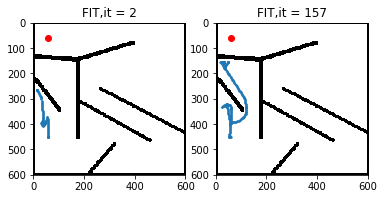

In [102]:
plot_trajectories_at_steps("res_fastsim_FIT_2020_12_22_12:32:50",method="FIT")

Comme on peut le voire le gradient deceptif n'arrive pas a trouver la sortie en 200 ittérations.

### 2.2 Variante NS

Mêmes questions avec la variante NS: lancez quelques expériences avec cette variante et indiquez le nombre moyen de générations pour atteindre la sortie (avec un nombre maximum de générations de 200). 

Tracez les trajectoires générées par les individus qui ont fait progresser la fitness pendant une expérience.

In [73]:
# <à compléter>
ns_df = df[df.Execution.str.contains("m_NS_")]
min_gen = ns_df[df.exit_reached == 1.0].groupby(df.Execution)["Generation"].min()
min_gen = np.array(min_gen)
print(min_gen,", moyenne : ",min_gen.mean())

[51 73] , moyenne :  62.0


/home/mohamed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


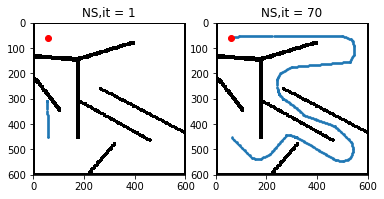

In [74]:
plot_trajectories_at_steps("res_fastsim_NS_2020_12_22_12:16:07",method="NS")

En revanche ici l'agent parviens au bout des 200 itérations a trouver la sortie comme prévu.

### 2.3 Variante FIT+NS

Mêmes questions avec la variante qui utilise 2 objectifs: Fitness et Novelty (variante FIT+NS). Lancez quelques expériences avec cette variante et indiquez le nombre moyen de générations pour atteindre la sortie (avec un nombre maximum de générations de 200). 

Tracez les trajectoires générées par les individus qui ont fait progresser la fitness pendant une expérience.

In [75]:
# <à compléter>
ns_df = df[df.Execution.str.contains("FIT_NS_")]
min_gen = ns_df[df.exit_reached == 1.0].groupby(df.Execution)["Generation"].min()
min_gen = np.array(min_gen)
print(min_gen)
min_gen.mean()

[66 14 21 42 89 25]


/home/mohamed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


42.833333333333336

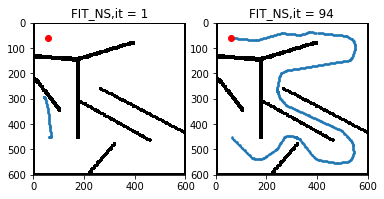

In [189]:
plot_trajectories_at_steps("res_fastsim_FIT_NS_2020_12_22_08:01:10",method="FIT_NS")

On remarque que la politique générée est sensiblement la même cependant l'apprentissage ayant été guidé par une pression de sélection globale vers l'objectif la première génération a atteindre l'objectif vient plus tôt que pour la variante NS.

## 3 Diversité des comportements générés




La position finale de chaque point généré est enregistrée dans le fichier info.log (champ robot_pos). Tracez ces différents points sur une même figure pour une experience de NS, de FIT et de FIT+NS. Vous tracerez sur une figure l'ensemble des points générés par une expérience de chaque variante. Qu'en déduisez-vous sur la capacité d'exploration de chacun de ces algorithmes ? Vous pourrez le comparer à un échantillonnage aléatoire (il suffit de mettre 0 générations et pour mu le nombre d'échantillons souhaités).

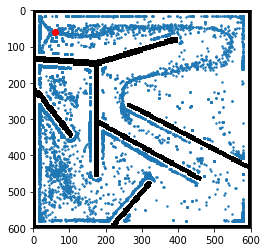

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7b760ea610>,
 <Figure size 432x288 with 1 Axes>)

In [87]:
"""
D'abord nous définissons ce constructeur de générateurs chaqu
générateur sert a générer efficacement différentes positions
prises par un élément quelconque de la population durant
l'évolution.
Ce constructeur prend en paramètre le nom d'un execution.
"""
def points_generator_constructor(execution_name):
    def points_generator():
        agg = df[df.Execution == execution_name].groupby("Generation")["dist_obj"]
        for k in agg.groups:
            pos_arr = np.array(df.loc[agg.groups[k]][["pos_x","pos_y"]])[:, :]
            for i in range(0,pos_arr.shape[0]):
                yield(*pos_arr[i],)
    return points_generator

g = points_generator_constructor("res_fastsim_FIT_NS_2020_12_22_08:01:10")()
points = [(i[0],i[1]) for i in g]
# pour tracer un ensemble de points, vous pourrez utiliser maze_plot.plot_points(pts)
plot_points(points)

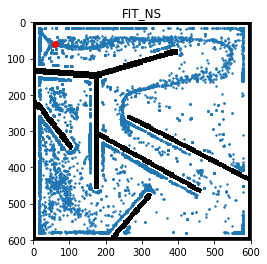

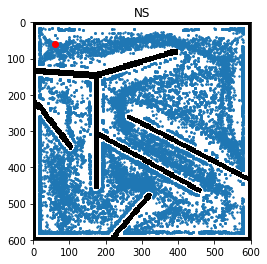

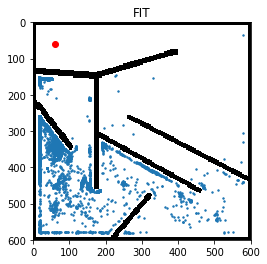

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7b6b2bde10>,
 <Figure size 432x288 with 1 Axes>)

In [106]:
g = points_generator_constructor("res_fastsim_FIT_NS_2020_12_22_08:01:10")()
points = [(i[0],i[1]) for i in g]

g = points_generator_constructor("res_fastsim_NS_2020_12_22_12:16:07")()
points2 = [(i[0],i[1]) for i in g]

g = points_generator_constructor("res_fastsim_FIT_2020_12_22_12:32:50")()
points3 = [(i[0],i[1]) for i in g]

plot_points(points,title="FIT_NS")
plot_points(points2,title="NS")
plot_points(points3,title="FIT")

Comme prévu les dispersion des points montrent bien l'inclinaison des différentes approches a la diversité.


Le nuage le plus intéressant a observer est le nuage de la variante FIT_NS et notamment dans la façon qu'ont les points de négocier le dernier virage, ils prennent un angle qui montre bien l'effet de la sélection multi-objectif et de la pression de l'objectif, mais ça se verra encore mieux avec les animations.

Tracez sur des figures séparées les points générés pour plusieurs générations successives de NS, FIT et FIT+NS (par exemple 90, 91, 92). Que constatez vous ? 

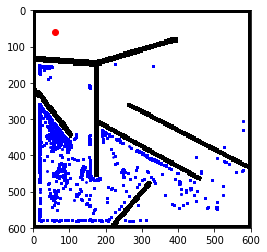

In [171]:
"""
Ici a la place de générer les points de trois itérations successives on a préféré créer des petites
animations qui montrent mieux l'évolution de la répartition des points.
"""


execution_name = "res_fastsim_FIT_2020_12_22_12:32:50"
agg = df[df.Execution == execution_name][["Generation", "pos_x","pos_y"]]
points_to_plot = []
for i in np.unique(df.Generation)[1:]:
    arr = np.array(agg[agg.Generation == i][["pos_x","pos_y"]])
    points_to_plot.append(arr)
points_to_plot = np.array(points_to_plot)
i = 0
def plot_animation(points_to_plot):
    fig1, ax1 = plt.subplots()
    X,Y = [],[]
    
    ax1.scatter([goal[0]],[goal[1]], c="red")
    sc = ax1.scatter([],[], c="red")
    i=0
    
    def init():
        ax1.set_xlim(0,600)
        ax1.set_ylim(600,0) # Decreasing
        img = plt.imread(bg)
        ax1.imshow(img, extent=[0, 600, 600, 0])
        i=0
        return ax1,
    
    def updatefig(frame):
        global i
        points = points_to_plot[i]
        i = i + 1
        for point in points:
            X.append(point[0])
            Y.append(point[1])
        sc = ax1.scatter(X,Y, c="blue",s=2)
            
            
    ani = animation.FuncAnimation(fig1, updatefig,init_func=init,frames=len(points_to_plot))
    from IPython.display import HTML
    return HTML(ani.to_jshtml())
ind = np.unique(np.random.randint(len(points_to_plot), size=100))
plot_animation(points_to_plot[ind])

Comme on peut le voire la génération de points continue a génerer des points dans l'angle de l'impasse la plus proche même dans les dernière itérations ce qui indique qu'une grande proportion de la population continue de générer des trajectoires qui s'engouffrent dans l'impasse.

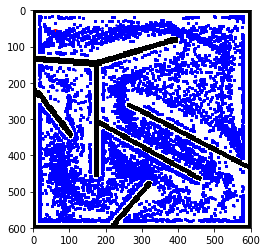

In [172]:
execution_name = "res_fastsim_NS_2020_12_22_12:16:07"
agg = df[df.Execution == execution_name][["Generation", "pos_x","pos_y"]]
points_to_plot = []
for i in np.unique(df.Generation)[1:]:
    arr = np.array(agg[agg.Generation == i][["pos_x","pos_y"]])
    points_to_plot.append(arr)
points_to_plot = np.array(points_to_plot)
i = 0
def plot_animation(points_to_plot):
    fig1, ax1 = plt.subplots()
    X,Y = [],[]
    
    ax1.scatter([goal[0]],[goal[1]], c="red")
    sc = ax1.scatter([],[], c="red")
    i=0
    
    def init():
        ax1.set_xlim(0,600)
        ax1.set_ylim(600,0) # Decreasing
        img = plt.imread(bg)
        ax1.imshow(img, extent=[0, 600, 600, 0])
        i=0
        return ax1,
    
    def updatefig(frame):
        global i
        points = points_to_plot[i]
        i = i + 1
        for point in points:
            X.append(point[0])
            Y.append(point[1])
        sc = ax1.scatter(X,Y, c="blue",s=2)
            
            
    ani = animation.FuncAnimation(fig1, updatefig,init_func=init,frames=len(points_to_plot))
    from IPython.display import HTML
    return HTML(ani.to_jshtml())
ind = np.unique(np.random.randint(len(points_to_plot), size=100))
plot_animation(points_to_plot[ind])

Remarque importante, afin que l'animation soit possible je ne génére pas tout les points de toutes les générations mais en revanche j'en genère le même nombre a chaque expérience avec un échantillonnage similaire.
Donc ici il n'y a pas plus de points que dans l'expérience suivante, ils sont juste trés trés bien répartis sur l'ensemble de l'espace phénotypique.

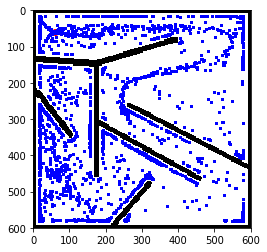

In [174]:
execution_name = "res_fastsim_FIT_NS_2020_12_22_08:01:10"
agg = df[df.Execution == execution_name][["Generation", "pos_x","pos_y"]]
points_to_plot = []
for i in np.unique(df.Generation)[1:]:
    arr = np.array(agg[agg.Generation == i][["pos_x","pos_y"]])
    points_to_plot.append(arr)
points_to_plot = np.array(points_to_plot)
i = 0
def plot_animation(points_to_plot):
    fig1, ax1 = plt.subplots()
    X,Y = [],[]
    
    ax1.scatter([goal[0]],[goal[1]], c="red")
    sc = ax1.scatter([],[], c="red")
    i=0
    
    def init():
        ax1.set_xlim(0,600)
        ax1.set_ylim(600,0) # Decreasing
        img = plt.imread(bg)
        ax1.imshow(img, extent=[0, 600, 600, 0])
        i=0
        return ax1,
    
    def updatefig(frame):
        global i
        points = points_to_plot[i]
        i = i + 1
        for point in points:
            X.append(point[0])
            Y.append(point[1])
        sc = ax1.scatter(X,Y, c="blue",s=2)
            
            
    ani = animation.FuncAnimation(fig1, updatefig,init_func=init,frames=len(points_to_plot))
    from IPython.display import HTML
    return HTML(ani.to_jshtml())
ind = np.sort(np.unique(np.random.randint(len(points_to_plot), size=100)))
plot_animation(points_to_plot[ind])

Comme on peut le voire il y'a un dispersion moins importante que pour dans l'animation précédente et que l'animation subit l'influence de la pression de sélection qui la conduit a atteindre l'objectif plus rapidement.

## 4 Ajout d'une qualité locale

L'ensemble des solutions générées peut être utilisé pour atteindre n'importe lequel des comportements atteignables, mais l'inconvénient de cette approche est que la notion de qualité est totalement absente du processus, or parmi les solutions générant un comportement donné, toutes ne se valent pas. Certaines sont plus intéressantes que d'autres parce qu'elle consomment moins d'énergie, qu'elles ne créent pas de collision, etc.

Une solution pour prendre en compte un tel critère de qualité consiste à utiliser, à côté de l'objectif de nouveauté, un objectif de performance. Définir cet objectif comme une pression globale est contreproductif, car pour éviter des collisions ou minimiser la consommation d'énergie, il suffit de ne pas bouger... Pour rendre cette pression plus intéressante, il faut en faire un objectif non pas global, mais local.

Pour cela, on peut suivre l'approche proposée par Lehman et Stanley [1]: on compare la fitness de l'individu considéré avec celle de ses plus proches voisins (qui sont déjà déterminés pour le calcul de nouveauté). L'objectif de compétition locale vaut le nombre de voisins dont la fitness est inférieure.

Complétez le code de novelty_search.py pour que la fonction de calcul de nouveauté renvoie la nouveauté et l'objectif de compétition locale. Pour cela, vous devrez garder dans l'archive la liste des fitness des points ajoutés.

Utilisez cette nouvelle version pour générer des politiques qui permettent d'atteindre les différentes positions du labyrinthe en minimisant le nombre de collision du robot avec les murs, par exemple.

Vous tracerez les trajectoires des meilleurs individus générés.

* [1] Lehman, J., & Stanley, K. O. (2011). Evolving a diversity of virtual creatures through novelty search and local competition. In Proceedings of GECCO

In [392]:
df[df.Execution.str.contains("m_NSLC")].groupby("Execution").exit_reached.max()

Execution
res_fastsim_NSLC_2020_12_23_12:23:45    0.0
res_fastsim_NSLC_2020_12_23_12:37:04    0.0
res_fastsim_NSLC_2020_12_23_13:00:22    1.0
res_fastsim_NSLC_2020_12_23_13:23:27    0.0
res_fastsim_NSLC_2020_12_23_13:47:23    0.0
res_fastsim_NSLC_2020_12_23_14:10:52    0.0
res_fastsim_NSLC_2020_12_23_14:43:27    0.0
res_fastsim_NSLC_2020_12_23_14:48:48    0.0
res_fastsim_NSLC_2020_12_23_14:54:12    0.0
res_fastsim_NSLC_2020_12_23_15:00:14    0.0
res_fastsim_NSLC_2020_12_23_15:06:09    0.0
Name: exit_reached, dtype: float64

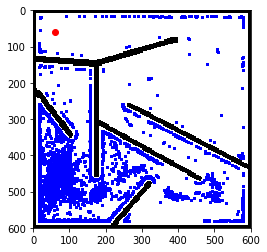

In [238]:
execution_name = "res_fastsim_NSLC_2020_12_23_15:00:14"
agg = df[df.Execution == execution_name][["Generation", "pos_x","pos_y"]]
points_to_plot = []
for i in np.unique(df.Generation)[1:]:
    arr = np.array(agg[agg.Generation == i][["pos_x","pos_y"]])
    points_to_plot.append(arr)
points_to_plot = np.array(points_to_plot)
i = 0
def plot_animation(points_to_plot):
    fig1, ax1 = plt.subplots()
    X,Y = [],[]
    
    ax1.scatter([goal[0]],[goal[1]], c="red")
    sc = ax1.scatter([],[], c="red")
    i=0
    
    def init():
        ax1.set_xlim(0,600)
        ax1.set_ylim(600,0) # Decreasing
        img = plt.imread(bg)
        ax1.imshow(img, extent=[0, 600, 600, 0])
        i=0
        return ax1,
    
    def updatefig(frame):
        global i
        points = points_to_plot[i]
        i = i + 1
        for point in points:
            X.append(point[0])
            Y.append(point[1])
        sc = ax1.scatter(X,Y, c="blue",s=2)
            
    ani = animation.FuncAnimation(fig1, updatefig,init_func=init,frames=len(points_to_plot))
    from IPython.display import HTML
    return HTML(ani.to_jshtml())
ind = np.sort(np.unique(np.random.randint(len(points_to_plot), size=150)))
plot_animation(points_to_plot[ind])

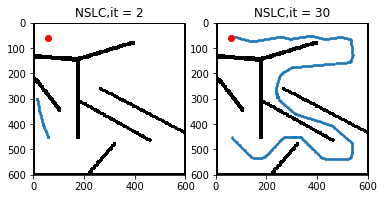

In [393]:
plot_trajectories_at_steps("res_fastsim_NSLC_2020_12_23_13:00:22",method="NSLC")

Comme on peut le voire l'agent arrive parfaitement a atteindre l'objectif, cependant on remarque que le nombre d'agents a rentrer en collisions avec les parois qui sont proches de l'objectif est très largement réduis et cela s'explique probablement par le fait que les agents qui explore jusque la sont issues de plusieurs générations et donc ont déja eu le temps d'acquérir un mécanismes diminuant leur probabilité d'entrer en collision avec un mur qui se trouve face a eux par exemple.

## 5 "Illuminer" l'espace exploré

### 5.1 Quantifier l'espace comportemental exploré

Définissez une grille dans l'espace comportemental qui va vous permettre de mesurer l'espace exploré. Découpez l'espace en cases (vous ignorerez les murs pour simplifier) et écrivez une fonction permettant de placer un individu dans case correspondant à son descripteur comportemental une fois qu'il a été évalué. Il n'y aura qu'un seul individu par case. Lorsque vous tentez d'ajouter un individu dans une case, si elle est déjà remplie, le nouvel individu remplacera l'ancien si sa fitness est plus élevée. 

Cette grille est (pour l'instant) indépendante de l'algorithme d'apprentissage. Elle vise simplement à mesurer la capacité de ce dernier à explorer cet espace et à retrouver facilement, si besoin, une politique efficace permettant d'atteindre un comportement donné.

Vous mesurerez la couverture de votre exploration (pourcentage de cellules explorées). Utilisez une grille de 100x100 cases sur l'expérience de navigation dans le labyrinthe et déterminez la couverture pour les trois variantes: FIT, NS, FIT+NS et NSLC (vous vous contenterez d'une seule expérience).

A la fin de votre expérience, vous afficherez le nombre de cellules que vous pouvez atteindre sans collision. Vous tracerez les trajectoires associées à quelques unes d'entre elles.

In [56]:
import random
import functools
import math
import numpy as np
def stat_grid(grid, dim=[100, 100]):
    if(len(grid.values())==0):
        print("Empty grid: no stats...")
        return

    nb_filled=0
    max_v=None
    for i in range(dim[0]):
        for j in range(dim[1]):
            if ((i,j) in grid.keys()):
                nb_filled+=1
                
    nbcells=functools.reduce(lambda x, y: x*y, dim)
    c_values=[ind for ind in list(grid.values())]
    max_v=max(c_values)
    total_quality=sum(c_values)
    #print("Number of evaluations: %d"%(nb_eval))
    print("Coverage: %.2f %% (%d cells out of %d)"%(float(nb_filled)/float(nbcells)*100., nb_filled, nbcells)+" Max score: %.2f"%(max(c_values))+" Min score: %.2f"%(min(c_values))+" Total quality: %.2f"%(total_quality))

In [70]:
L = os.listdir("completed_runs/")
executions_maps = {}
coverage_maps = {}
for i in L:
    dirs = os.listdir("completed_runs/"+i)
    if("map.dat" in dirs):
        with open("completed_runs/"+i+"/map.dat") as f:
            l = f.readlines()
            for k in l:
                vect = [float(j) for j in (k.strip().replace("===","123456789").split(" "))]
                cov = [0 if j =="===" else 1 for j in (k.strip().split(" "))]
                executions_maps[i] = executions_maps.get(i,[]) + vect
            executions_maps[i] = np.array(executions_maps[i]).reshape((100,100))
            grid = {}
            for k1 in range(executions_maps[i].shape[0]):
                for k2 in range(executions_maps[i].shape[1]):
                    if(executions_maps[i][k1][k2] != 123456789):
                        grid[(k1,k2)] = executions_maps[i][k1][k2]
            executions_maps[i] = grid
                    

for i in executions_maps:
    print("exeuction = ",i)
    stat_grid(executions_maps[i])

exeuction =  res_fastsim_NS_2020_12_23_23:02:35
Coverage: 40.76 % (4076 cells out of 10000) Max score: 1000.00 Min score: 0.00 Total quality: 3248015.00
exeuction =  res_fastsim_NSLC_2020_12_23_23:31:18
Coverage: 19.42 % (1942 cells out of 10000) Max score: 1000.00 Min score: 0.00 Total quality: 610095.00
exeuction =  res_fastsim_NSLC_2020_12_23_22:48:10
Coverage: 15.16 % (1516 cells out of 10000) Max score: 1000.00 Min score: 0.00 Total quality: 373115.00
exeuction =  res_fastsim_FIT_2020_12_23_23:31:05
Coverage: 4.41 % (441 cells out of 10000) Max score: 1000.00 Min score: 0.00 Total quality: 101988.00
exeuction =  res_fastsim_NS_2020_12_23_21:24:38
Coverage: 41.98 % (4198 cells out of 10000) Max score: 1000.00 Min score: 0.00 Total quality: 3353643.00
exeuction =  res_fastsim_FIT_NS_2020_12_23_21:40:50
Coverage: 30.55 % (3055 cells out of 10000) Max score: 1000.00 Min score: 0.00 Total quality: 2468986.00


In [76]:
for i in executions_maps:
    print("Execution : ",i,"a comme nombre de cellules atteignables sans collisions : ",sum([1 if i==0 else 0 for i in executions_maps[i].values()]))


Execution :  res_fastsim_NS_2020_12_23_23:02:35 a comme nombre de cellules atteignables sans collisions :  3
Execution :  res_fastsim_NSLC_2020_12_23_23:31:18 a comme nombre de cellules atteignables sans collisions :  4
Execution :  res_fastsim_NSLC_2020_12_23_22:48:10 a comme nombre de cellules atteignables sans collisions :  3
Execution :  res_fastsim_FIT_2020_12_23_23:31:05 a comme nombre de cellules atteignables sans collisions :  7
Execution :  res_fastsim_NS_2020_12_23_21:24:38 a comme nombre de cellules atteignables sans collisions :  4
Execution :  res_fastsim_FIT_NS_2020_12_23_21:40:50 a comme nombre de cellules atteignables sans collisions :  3


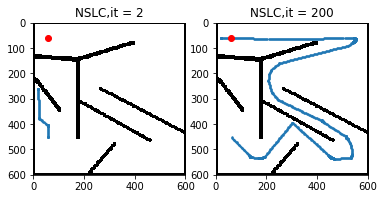

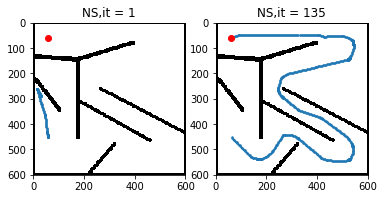

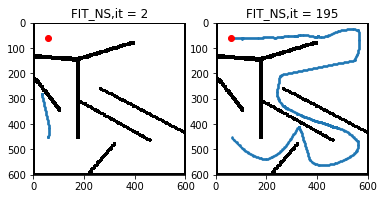

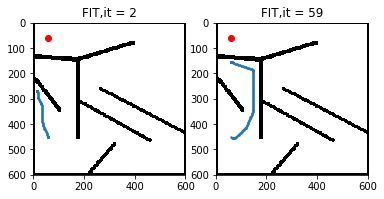

In [65]:
plot_trajectories_at_steps("res_fastsim_NSLC_2020_12_23_22:48:10",method="NSLC")
plot_trajectories_at_steps("res_fastsim_NS_2020_12_23_21:24:38",method="NS")
plot_trajectories_at_steps("res_fastsim_FIT_NS_2020_12_23_21:40:50",method="FIT_NS")
plot_trajectories_at_steps("res_fastsim_FIT_2020_12_23_23:31:05",method="FIT")

### 5.2 OPTION: MAP-Elites

#### 5.2.1 Implémentation de MAP-Elites

La grille définie à la question précédente permet de définir un algorithme très simple: MAP-Elites [1]. Dans cet algorithme, la sélection s'appuie sur la grille. La génération d'un nouvel individu consiste à tirer aléatoirement un (si mutation uniquement) ou deux individus (si croisement) dans la grille puis à appliquer l'opérateur génétique de mutation ou de croisement. Après évaluation, on tente d'ajouter cet individu dans la grille et on 

Utilisez cet algorithme sur la tâche de navigation et indiquer le nombre de cellules atteignables sans collision. Vous pourrez tracer des trajectoires associées à quelques unes d'entre elles.


MAP-Elites est un algorithme très simple. Le prix à payer est qu'il est bien plus lent que Novelty search pour couvrir l'espace atteignable. Ses performances peuvent être améliorées si le génotype est de plus petite taille. 

* [1] Mouret, J. B., & Clune, J. (2015). Illuminating search spaces by mapping elites. arXiv preprint arXiv:1504.04909

In [5]:
registered_envs={}


# all parameters of a run are here, change it or duplicate it to explore different possibilities
# the parameters are grouped into subset of parameters to limite their duplication.
# They are concatenated below to create registered_envs entries.


fastsim_env0={
    'gym_name': 'FastsimSimpleNavigation-v0',
    'env_params': {"still_limit": 10, 'reward_kind': "continuous"},

    'nb_input': 5, # number of NN inputs
    'nb_output': 2, # number of NN outputs
    'nb_layers': 2, # number of layers
    'nb_neurons_per_layer': 10, # number of neurons per layer

    'episode_nb_step': 1000, # maximum number of steps during an episode
    'episode_reward_kind': 'final', # 2 possible values: 'final' (the reward of an episode is the last observed reward and 'cumul' (the reward of an episode is the sum of all observed rewards
    'episode_bd': 'robot_pos', # the info key value to use as a bd
    'episode_bd_slice': (0,2,None), # specify the slice of the BD you are interested in (start, stop, step), see slice function. put (None, None, None) if you want everything
    'episode_bd_kind': 'final', # only final for the moment
    'episode_log': {'collision': 'cumul', 
                    'dist_obj': 'final', 
                    'exit_reached': 'final', 
                    'robot_pos': 'final'},

    'dim_grid': [100, 100],
    'grid_min_v': [0,0],
    'grid_max_v': [600,600],
    'goal': [60,60],

    'watch_max': 'dist_obj', # watching for the max in the corresponding info entry
}




fastsim_env1={
    'gym_name': 'FastsimSimpleNavigation-v0',
    'env_params': {"still_limit": 10, 'reward_kind': "continuous"},

    'nb_input': 5, # number of NN inputs
    'nb_output': 2, # number of NN outputs
    'nb_layers': 2, # number of layers
    'nb_neurons_per_layer': 10, # number of neurons per layer

    'episode_nb_step': 1000, # maximum number of steps during an episode
    'episode_reward_kind': 'final', # 2 possible values: 'final' (the reward of an episode is the last observed reward and 'cumul' (the reward of an episode is the sum of all observed rewards
    'episode_bd': 'robot_pos', # the info key value to use as a bd
    'episode_bd_slice': (0,2,None), # specify the slice of the BD you are interested in (start, stop, step), see slice function. put (None, None, None) if you want everything
    'episode_bd_kind': 'final', # only final for the moment
    'episode_log': {'collision': 'cumul', 
                    'dist_obj': 'final', 
                    'exit_reached': 'final', 
                    'robot_pos': 'final'},

    'dim_grid': [100, 100],
    'grid_min_v': [0,0],
    'grid_max_v': [600,600],
    'goal': [60,60],

    'watch_max': 'collisions', # watching for the max in the corresponding info entry
}

fastsim_env2={
    'gym_name': 'FastsimSimpleNavigation-v0',
    'env_params': {"still_limit": 10, 'reward_kind': "collisions"},

    'nb_input': 5, # number of NN inputs
    'nb_output': 2, # number of NN outputs
    'nb_layers': 2, # number of layers
    'nb_neurons_per_layer': 10, # number of neurons per layer

    'episode_nb_step': 1000, # maximum number of steps during an episode
    'episode_reward_kind': 'cumul', # 2 possible values: 'final' (the reward of an episode is the last observed reward and 'cumul' (the reward of an episode is the sum of all observed rewards
    'episode_bd': 'robot_pos', # the info key value to use as a bd
    'episode_bd_slice': (0,2,None), # specify the slice of the BD you are interested in (start, stop, step), see slice function. put (None, None, None) if you want everything
    'episode_bd_kind': 'final', # only final for the moment
    'episode_log': {'collision': 'cumul', 
                    'dist_obj': 'final', 
                    'exit_reached': 'final', 
                    'robot_pos': 'final'},

    'dim_grid': [100, 100],
    'grid_min_v': [0,0],
    'grid_max_v': [600,600],
    'goal': [60,60],
    'watch_max': 'dist_obj', # watching for the max in the corresponding info entry

}

ea_generic={
    'min_value': -30, # min genotype value
    'max_value': 30, # max genotype value
    'min_strategy': 0.5, # min value for the mutation
    'max_strategy': 3, # max value for the mutation
    'nb_gen': 200, #10, # number of generations
    'mu': 100, # population size
    'lambda': 200, # number of individuals generated
    'nov_k': 15, # k parameter of novelty search
    'nov_add_strategy': "random", # archive addition strategy (either 'random' or 'novel')
    'nov_lambda': 6, # number of individuals added to the archive
}

ea_random_sampling={
    'min_value': -30, # min genotype value
    'max_value': 30, # max genotype value
    'min_strategy': 0.5, # min value for the mutation
    'max_strategy': 3, # max value for the mutation
    'nb_gen': 0, # number of generations
    'mu': 10000, #200100 # population size
    'lambda': 200, # number of individuals generated
    'nov_k': 15, # k parameter of novelty search
    'nov_add_strategy': "random", # archive addition strategy (either 'random' or 'novel')
    'nov_lambda': 6, # number of individuals added to the archive
}



ea_generic={
    'min_value': -30, # min genotype value
    'max_value': 30, # max genotype value
    'min_strategy': 0.5, # min value for the mutation
    'max_strategy': 3, # max value for the mutation
    'nb_gen': 200, #10, # number of generations
    'mu': 100, # population size
    'lambda': 200, # number of individuals generated
    'nov_k': 15, # k parameter of novelty search
    'nov_add_strategy': "random", # archive addition strategy (either 'random' or 'novel')
    'nov_lambda': 6, # number of individuals added to the archive
}

ea_NS={
    'selection': 'NS', # can be either NS, FIT or FIT+NS
}

ea_FIT={
    'selection': 'FIT', # can be either NS, FIT or FIT+NS
}

ea_FIT_NS={
    'selection': 'FIT+NS', # can be either NS, FIT or FIT+NS
}



# Fastsim with NS
registered_envs["fastsim_NS"]={}
registered_envs["fastsim_NS"].update(fastsim_env1)
registered_envs["fastsim_NS"].update(ea_generic)
registered_envs["fastsim_NS"].update(ea_NS)


# Fastsim with FIT
registered_envs["fastsim_FIT"]={}
registered_envs["fastsim_FIT"].update(fastsim_env1)
registered_envs["fastsim_FIT"].update(ea_generic)
registered_envs["fastsim_FIT"].update(ea_FIT)

# Fastsim with FIT and NS (multi-objective approach)
registered_envs["fastsim_FIT_NS"]={}
registered_envs["fastsim_FIT_NS"].update(fastsim_env1)
registered_envs["fastsim_FIT_NS"].update(ea_generic)
registered_envs["fastsim_FIT_NS"].update(ea_FIT_NS)

# Fastsim with random sampling
registered_envs["fastsim_RANDOM"]={}
registered_envs["fastsim_RANDOM"].update(fastsim_env1)
registered_envs["fastsim_RANDOM"].update(ea_random_sampling)
registered_envs["fastsim_RANDOM"].update(ea_FIT_NS)


registered_envs["fastsim_NSLC"]={}
registered_envs["fastsim_NSLC"].update(fastsim_env2)
registered_envs["fastsim_NSLC"].update(ea_generic)
registered_envs["fastsim_NSLC"].update(ea_NS)

env_name = "fastsim_FIT_NS"

In [48]:
def get_grid_coord(bd, dim=[100, 100], min_v=[0,0], max_v=[1, 1]):
    x1 = np.linspace(min_v[0], max_v[0], dim[0], endpoint=False)
    x2 = np.linspace(min_v[1], max_v[1], dim[1], endpoint=False)
    return ((x1 > bd[0]).astype("int").argmax() - 1 ,(x2 > bd[1]).astype("int").argmax() -1)

def add_to_grid(grid,ind, local_quality, dim=[100, 100], min_v=[0,0], max_v=[1, 1]):
    (x,y) = get_grid_coord(ind.bd ,dim = dim, min_v = min_v, max_v=max_v)
    ind.local_quality = local_quality
    if((x,y) in grid and ind.local_quality > grid[(x,y)].local_quality):
        #print((x,y) , "-> updated to : ",ind.log["collision"], " cuz it's less than : ",grid[(x,y)].log["collision"])
        grid[(x,y)] = ind
    elif ((x,y) not in grid):
        grid[(x,y)] = ind

In [49]:
# Individual generator
env = gym.make('FastsimSimpleNavigation-v0', **{"still_limit": 10, 'reward_kind': "continuous"})


def generateES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

def checkStrategy(minstrategy):
    def decorator(func):
        def wrappper(*args, **kargs):
            children = func(*args, **kargs)
            for child in children:
                for i, s in enumerate(child.strategy):
                    if s < minstrategy:
                        child.strategy[i] = minstrategy
            return children
        return wrappper
    return decorator


def eval_nn(genotype, resdir, render=False, dump=False, name=""):
    """ Evaluation of a neural network. Returns the fitness, the behavior descriptor and a log of what happened
        Consider using dump=True to generate log files. These files are put in the resdir directory.
    """
    nbstep=10000
    nn=SimpleNeuralControllerNumpy(5,2,2,10)
    center=nn.get_parameters()
    nn.set_parameters(genotype)
    observation = env.reset()
    observation, reward, done, info = env.step([0]*registered_envs[env_name]["nb_output"]) # if we forget that, the initial perception may be different from one eval to another... 
    #print("First observation: "+str(observation)+" first pos: "+str(env.get_robot_pos()))
    action_scale_factor = env.action_space.high
    episode_reward=0
    episode_bd=None
    episode_log={}
    for t in range(nbstep):
        if render:
            env.render()
        action=nn.predict(observation)
        action=action_scale_factor*np.array(action)
        #print("Observation: "+str(observation)+" Action: "+str(action))
        observation, reward, done, info = env.step(action) 
        if (registered_envs[env_name]["episode_reward_kind"] == "cumul"):
            episode_reward+=reward

        for k in registered_envs[env_name]["episode_log"].keys():
            if (registered_envs[env_name]["episode_log"][k] == "cumul"):
                if (k not in episode_log.keys()):
                    episode_log[k] = info[k]
                else:
                    episode_log[k] += info[k]
        if(done):
            break

    if (registered_envs[env_name]["episode_reward_kind"] == "final"):
        episode_reward=reward
        
    if (registered_envs[env_name]["episode_bd_kind"] == "final"):
        episode_bd=info[registered_envs[env_name]["episode_bd"]][slice(*registered_envs[env_name]["episode_bd_slice"])]
        
    for k in registered_envs[env_name]["episode_log"].keys():
        if (registered_envs[env_name]["episode_log"][k] == "final"):
            episode_log[k] = info[k]
    
    #print("End of eval, t=%d, total_dist=%f"%(t,total_dist))
    return episode_reward, episode_bd, episode_log

creator.create("MyFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode="d", fitness=creator.MyFitness, strategy=None)
creator.create("Strategy", array.array, typecode="d")

In [78]:
import grid_management
import datetime
import random

grid ={}


resdir="res_"+"MAP_ELITES"+"_"+datetime.datetime.now().strftime("%Y_%m_%d_%H:%M:%S")

nn=SimpleNeuralControllerNumpy(5,2,2,10)
center=nn.get_parameters()

mu = 200
lambda_= 100
IND_SIZE = center.shape[0]

CXPB=0.3
MUTPB=0.7

toolbox = base.Toolbox()
toolbox.register("individual", generateES, creator.Individual, creator.Strategy, IND_SIZE, 
ea_generic["min_value"], 
ea_generic["max_value"], 
ea_generic["min_strategy"], 
ea_generic["max_strategy"])

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.03)
toolbox.register("select", tools.selNSGA2)

toolbox.register("map",futures.map)
toolbox.decorate("mate", checkStrategy(ea_generic["min_strategy"]))
toolbox.decorate("mutate", checkStrategy(ea_generic["min_strategy"]))
toolbox.register("evaluate", eval_nn, resdir=resdir)



population = toolbox.population(n=mu)
paretofront = tools.ParetoFront()
logbook = tools.Logbook()
invalid_ind = [ind for ind in population]
fitnesses_bds = toolbox.map(toolbox.evaluate, invalid_ind)

for ind, (fit, bd, log) in zip(invalid_ind, fitnesses_bds):
    ind.fit = fit
    ind.log = log
    ind.bd = bd
    ind.fitness.values=(ind.fit,0)
    add_to_grid(grid,ind, ind.fit, dim=[100, 100], min_v=[0,0], max_v=[600,600])

stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)  

In [ ]:
for i in range(100):
    ind_sampled = [grid[key] for key in random.sample(list(grid.keys()), lambda_ if (lambda_ < len(grid.keys())) else len(grid.keys()))]    
    offspring = list(map(toolbox.clone, ind_sampled))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
        
    pq=population+offspring
    fitnesses_bds = toolbox.map(toolbox.evaluate, pq)
    for ind, (fit, bd, log) in zip(pq, fitnesses_bds):
        ind.fit = fit
        ind.log = log
        ind.bd = bd
        ind.fitness.values=(ind.fit,)
        grid_management.add_to_grid(grid,ind, ind.fit, dim=[100, 100], min_v=[0,0], max_v=[600,600])
        
        
    record = stats.compile(grid.values())
    logbook.header = "gen", *(record.keys())
    logbook.record(gen=i, **record)
    print(logbook.stream)

gen	avg     	std    	min     	max     
0  	-414.228	69.4584	-535.679	-258.021
1  	-411.479	72.4818	-535.679	-240.69 
2  	-408.365	72.8655	-535.679	-240.69 
3  	-407.967	71.9513	-535.679	-240.69 
4  	-406.567	74.1624	-535.679	-217.003
5  	-406.976	75.2812	-535.679	-217.003
6  	-409.179	76.2883	-535.679	-217.003
7  	-408.094	78.0583	-538.345	-217.003
8  	-407.969	77.3924	-538.345	-217.003
9  	-402.078	79.3697	-538.345	-205    


#### 5.2.2 Variantes de MAP-Elites

MAP-Elites peut aussi être amélioré avec des stratégies de choix des parents qui ne sont plus uniformes sur toute la grille, mais biaisées pour favoriser les cellules isolées ou les individus dont les descendants ont réussi à remplir des cellules (score de "curiosité" [1]). 

* [1] Cully, A., & Demiris, Y. (2017). Quality and diversity optimization: A unifying modular framework. IEEE Transactions on Evolutionary Computation, 22(2), 245-259.